In [1]:
import numpy as np
import pandas as pd

import scanpy as sc

from importlib import reload
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import benchmark_utils as bm

# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample dataset is provided and can be accessed using the ```load_data()``` method

In [3]:
from src.metacells.utils import load_data

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
ad = load_data()

# Pre-processing

todo

# Running Metacells

In [5]:
## User defined parameters

## Core parameters 
n_metacells = 10
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 1 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection




In [10]:
from src.metacells.core import Metacells
from sklearn.metrics import silhouette_score


model = Metacells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_metacells=n_metacells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

model.fit(n_iter=100)


Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Initializing residual matrix using greedy column selection
Initializing f and g...



Selecting 9 cells from waypoint initialization.
Selecting 1 cells from greedy initialization.
Setting convergence threshold at 0.006367160662289244
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Converged after 19 iterations.


# Accessing results

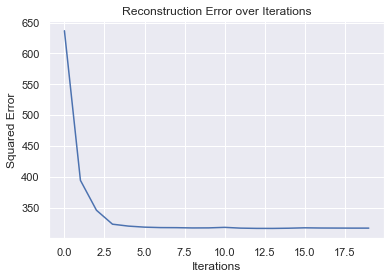

In [11]:
%matplotlib inline
# Check for convergence 
model.plot_convergence()

In [9]:
model.get_assignments()

,metacell_ID
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#ACGTTACAGAGGCTAA-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep1#ACTAACGGTCCAAATG-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#ACTAACTCATGTGGGA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#ACGTTGTAGGCTGTCA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#ACGTCCTTCAGTTCCC-1
...,...
cd34_multiome_rep1#ACTAACGGTAGGATTT-1,cd34_multiome_rep1#ACGTTGTAGGCTGTCA-1
cd34_multiome_rep1#ACTAACGGTATTGGTG-1,cd34_multiome_rep1#ACTAACTCATGTGGGA-1
cd34_multiome_rep1#ACTAACGGTCCAAATG-1,cd34_multiome_rep1#ACTAACGGTCCAAATG-1


# Visualizing Results

PKG also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_metacell_sizes``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

In [16]:
# Load the plotting functions as plot
from src.metacells import plot

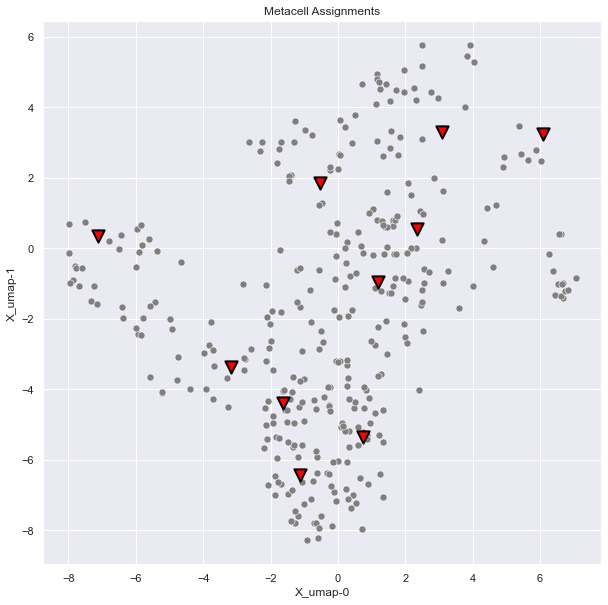

In [17]:
plot.plot_2D(ad, key='X_umap', colour_metacells=False)

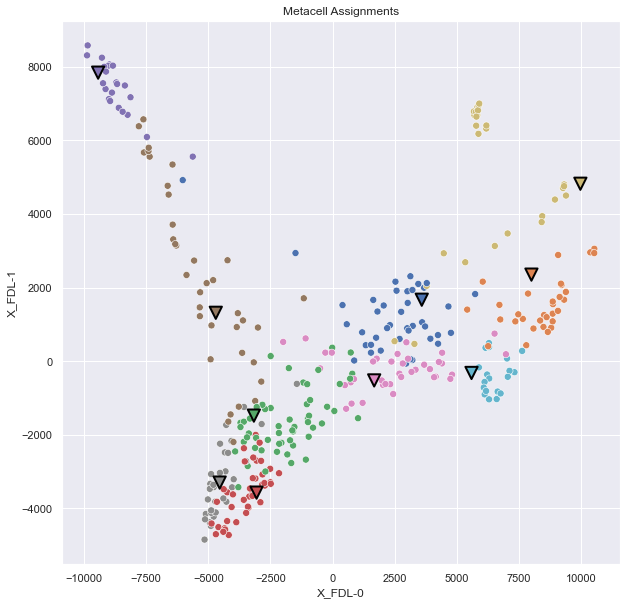

In [18]:
plot.plot_2D(ad, key = 'X_FDL', colour_metacells=True)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


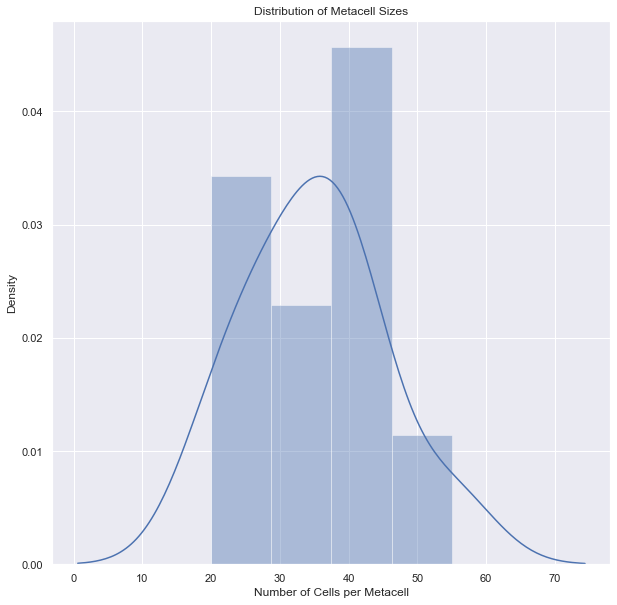

In [19]:
plot.plot_metacell_sizes(ad)

## Evaluate metacell results

In [20]:
from src.metacells import evaluate
reload(evaluate)

<module 'src.metacells.evaluate' from '/Users/sitarapersad/tmp_mcs/metacells/notebooks/../src/metacells/evaluate.py'>

In [21]:
nbrs, nlls = evaluate.get_NLLs(ad)

Computing 5 neighbours in diffusion component space and Gaussian from X_pca space.
Determing nearest neighbor graph...
Clipping to metacells with at least 3 cells.
Dropping 0 metacell(s) due to insufficient size.
Clipping to metacells with at least 3 cells.
Dropping 0 metacell(s) due to insufficient size.
Computing 5 neighbours in diffusion component space and Gaussian from X_pca space.
Determing nearest neighbor graph...


In [22]:
# We can optionally filter to only consider separation for metacells whose neighbours have the same cell type
nbrs_f, nlls_f = evaluate.filter_neighbours(nbrs, nlls, cluster='celltype')

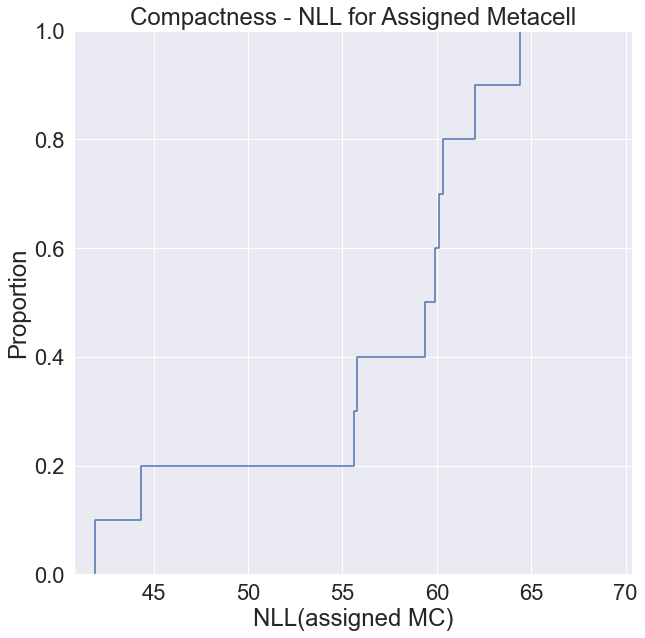

In [26]:
evaluate.plot_compactness(nlls)

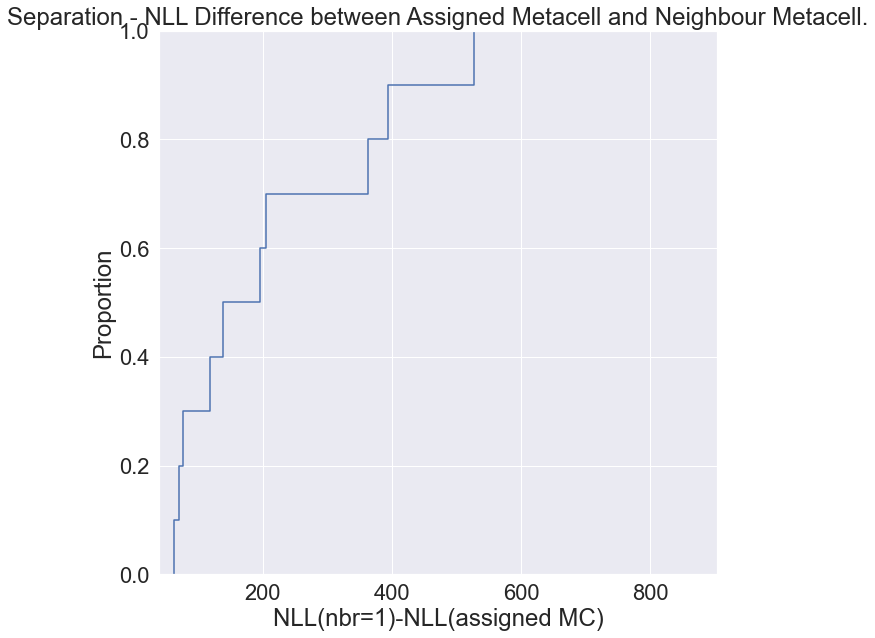

In [25]:
evaluate.plot_separation(nlls)